In [2]:
run ../initialize.ipynb

Lax Version : 1.5.1


In [3]:
hax.init(experiment='XENON1T', 
        pax_version_policy = '6.8.0',
        main_data_paths = ['/project2/lgrandi/xenon1t/processed', '/project/lgrandi/xenon1t/processed'],
        minitree_paths = [
        '/scratch/midway2/jpienaar/minitrees/',
        '/project2/lgrandi/xenon1t/minitrees/pax_v6.8.0',
        '/project/lgrandi/xenon1t/minitrees/pax_v6.8.0',
        ],
        )  

### Load Data (Radon)

In [4]:
from PI_after_s1 import S1_ionization
from PI_after_s2 import S2_ionization

#### SR1

In [5]:
datasets = hax.runs.datasets # this variable holds all dataset info
datasets = hax.runs.tags_selection(include=['*sciencerun1'],
                                  exclude=['bad','messy', 'test',
                                           'nofield','lowfield',
                                           'commissioning',
                                           'pmttrip','trip','_pmttrip',
                                           'source_opening',
                                           ],
                                  )
datasets_radon = hax.cuts.selection(datasets, datasets['source__type']=='Rn220', 'Source in place')
datasets_radon = hax.cuts.selection(datasets_radon, datasets_radon['location'] != '', 'Processed data available')
run_numbers_radon = datasets_radon['number'].values
print('Total of %d datasets' % len(run_numbers_radon))


Source in place selection: 7257 rows removed (4.56% passed)
Processed data available selection: 0 rows removed (100.00% passed)
Total of 347 datasets


In [6]:
%%time
print('Loading data')
data_radon_sr1 = hax.minitrees.load(run_numbers_radon[:1],
                        treemakers = [S2_ionization, 'Basics'],
                        #preselection = ['s2 > 5000'],
                        num_workers=8,
                        #force_reload=True,
                        )
#data_radon['r'] = np.sqrt(data_radon['x']**2 + data_radon['y']**2)

Loading data
CPU times: user 28.5 s, sys: 44.1 s, total: 1min 12s
Wall time: 1min 56s


In [7]:
print('Loading data')
data_radon_sr1_events = hax.minitrees.load(run_numbers_radon[:1],
                        treemakers = ['Basics'],
                        #preselection = ['s2 > 5000'],
                        num_workers=8,
                        #force_reload=True,
                        )
#data_radon['r'] = np.sqrt(data_radon['x']**2 + data_radon['y']**2)

Loading data


In [8]:
len(data_radon_sr1_events)

198876

### Load Data (Krypton)

In [9]:
datasets = hax.runs.datasets # this variable holds all dataset info
datasets = hax.runs.tags_selection(include=['*sciencerun1'],
                                  exclude=['bad','messy', 'test',
                                           'nofield','lowfield',
                                           'commissioning',
                                           'pmttrip','trip','_pmttrip',
                                           'source_opening',
                                           ],
                                  )
datasets_kr = hax.cuts.selection(datasets, datasets['source__type']=='Kr83m', 'Source in place')
datasets_kr = hax.cuts.selection(datasets_kr, datasets_kr['location'] != '', 'Processed data available')
run_numbers_kr = datasets_kr['number'].values
print('Total of %d datasets' % len(run_numbers_kr))


Source in place selection: 7146 rows removed (6.02% passed)
Processed data available selection: 0 rows removed (100.00% passed)
Total of 458 datasets


In [10]:
%%time
print('Loading data')
data_kr_sr1 = hax.minitrees.load(run_numbers_kr[0:1],
                        treemakers = [S2_ionization, 'Basics'],
                        #preselection = ['s2 > 5000'],
                        num_workers=8,
                        #force_reload=True,
                        )
#data_radon['r'] = np.sqrt(data_radon['x']**2 + data_radon['y']**2)

Loading data
CPU times: user 12.7 s, sys: 19.5 s, total: 32.2 s
Wall time: 51.5 s


In [11]:
print('Loading data')
data_kr_sr1_events = hax.minitrees.load(run_numbers_kr[0:1],
                        treemakers = ['Basics'],
                        #preselection = ['s2 > 5000'],
                        num_workers=8,
                        #force_reload=True,
                        )
#data_radon['r'] = np.sqrt(data_radon['x']**2 + data_radon['y']**2)

Loading data


### Plots and Stuff

In [12]:
dict_data_sets={'SR1_Kr':data_kr_sr1, 'SR1_Rn':data_radon_sr1,}
dict_data_events={'SR1_Kr':data_kr_sr1_events, 'SR1_Rn':data_radon_sr1_events,}

In [40]:
def straight_line(x, m, c):
    return m*x+c

In [41]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare

def fit_straight_line(initial_guess, counts, xedges):
    
    xcenters = xedges[:-1]+(xedges[1:]-xedges[:-1])/2
    try:
        #Fit
        popt, pcov = curve_fit(straight_line, xcenters, counts, p0=initial_guess, maxfev=2500)
        
        #Determine chi square
        counts_fitted = straight_line(xcenters, *popt)
        f_goodness_of_fit = chisquare(counts, counts_fitted)
        fit_plot=plt.plot(xcenters, counts_fitted, linewidth=3, linestyle=':', color='black')
        
        
        return popt[0], popt[1], pcov[0][0], pcov[1][1], fit_plot, f_goodness_of_fit
    except RuntimeError:
        return -100, -100, 0, 0, 0, -100 


SR1_Kr
Lower Bound selection: 2620246 rows removed (15.86% passed)
Upper Bound selection: 469825 rows removed (4.88% passed)
Power_divergenceResult(statistic=0.10453481843815342, pvalue=1.0)


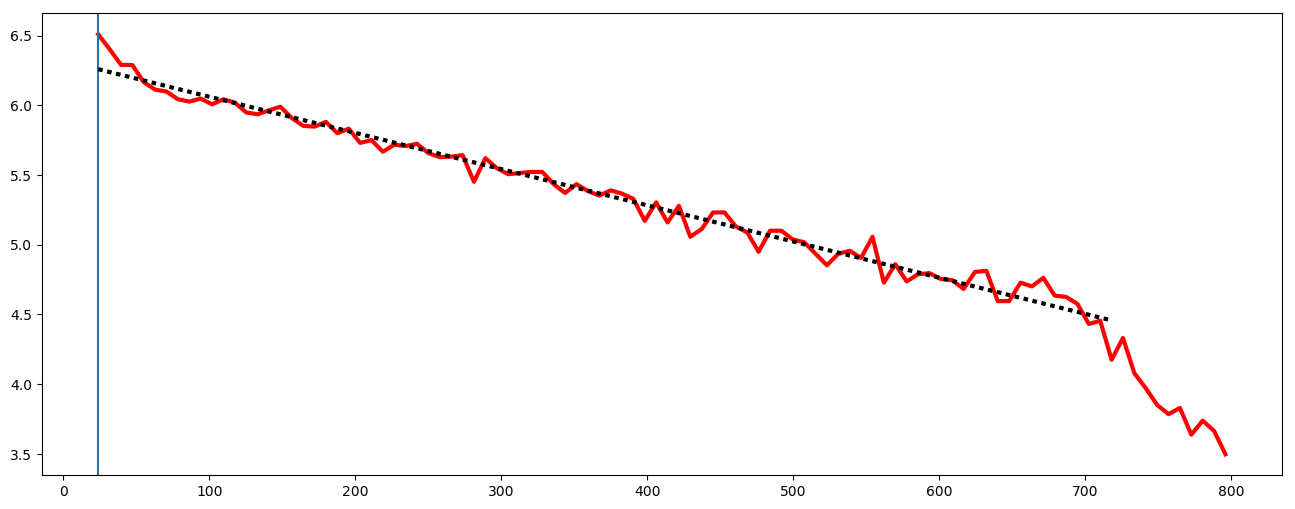

SR1_Rn
Lower Bound selection: 4357344 rows removed (35.59% passed)
Upper Bound selection: 2344672 rows removed (2.62% passed)
Power_divergenceResult(statistic=0.015427959206246098, pvalue=1.0)


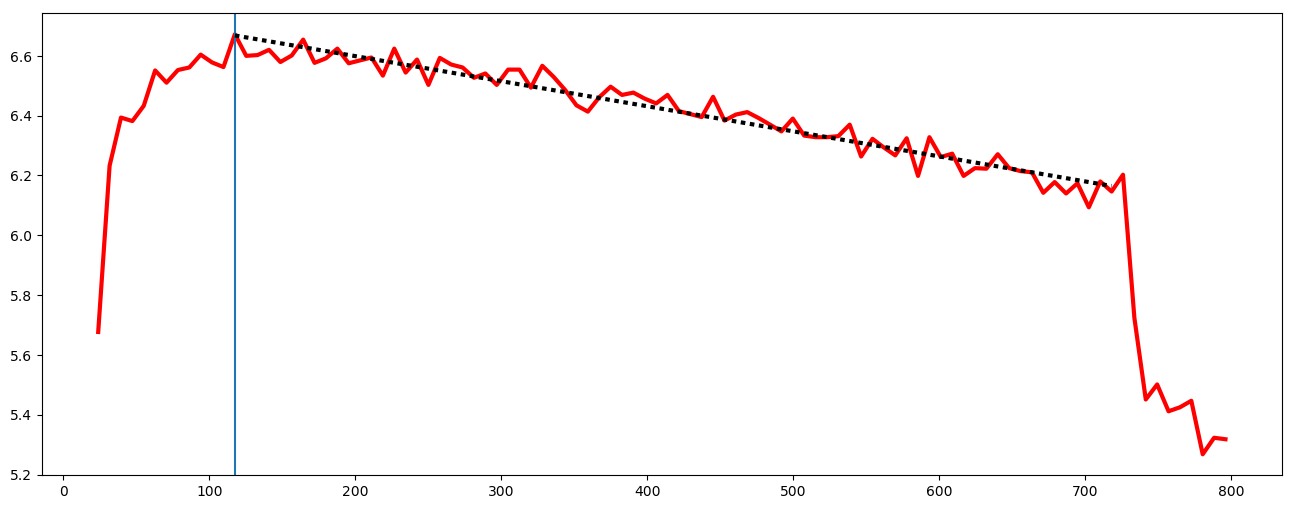

In [53]:
_bins=100
_xrange=[20,800]
for key, data in dict_data_sets.items():
    print(key)
    
    data=hax.cuts.selection(data, data['drift_time']>550000, "Lower Bound")
    data=hax.cuts.selection(data, data['drift_time']<560000, "Upper Bound")
    
    #Make Hist
    fig = plt.figure(figsize=(16, 6))
    (hist, bin_edges) = np.histogram(data['time_since_s2'].values/1000, bins = _bins, range = _xrange)
    hist_err=np.sqrt(hist)
    bins_width = (bin_edges[1:] - bin_edges[:-1])/2
    bin_centers = bin_edges[:-1] + bins_width
    plt.plot(bin_centers, np.log(hist), linewidth=3,  color='r')
    
    #Find maximum
    i_max_index = np.argmax(hist)
    plt.axvline(bin_centers[i_max_index], ymin=0, ymax=1)
    
    #Fit data
    if key=='SR1':
        i_last_index = np.searchsorted(bin_centers, 710, side="left")
        plt.axvline(bin_centers[i_last_index], ymin=0, ymax=1)
    if key=='SR0':
        i_last_index = np.searchsorted(bin_centers, 660, side="left")
        plt.axvline(bin_centers[i_last_index], ymin=0, ymax=1)
    (f_slope, _, f_slope_err, _, _, f_chisq) = fit_straight_line([-1, 5], np.log(hist[i_max_index:i_last_index]), 
                                                         bin_edges[i_max_index:i_last_index+1])
    print(f_chisq)
    
    #Set plot parameters
    #plt.yscale('log')
    plt.savefig('%s_example_decay.png' %key, bbox_inches='tight')
    #plt.savefig('%s_example_decay.pdf' %key, bbox_inches='tight')
    plt.show()

In [ ]:
_bins=100
_xrange=[20,800]
dict_fit_values={}
for key, data in dict_data_sets.items():
    print(key)
    array_fit_values=[]
    drift_time_bins=np.linspace(100, 600, 11)
    for idx, drift_time_cutoff in enumerate(drift_time_bins[:-1]):
        data_temp=hax.cuts.selection(data, data['drift_time']/1000>drift_time_cutoff, "Lower Bound")
        data_temp=hax.cuts.selection(data_temp, data_temp['drift_time']/1000<drift_time_bins[idx+1], "Upper Bound")

        #Make Hist
        fig = plt.figure(figsize=(16, 6))
        (hist, bin_edges) = np.histogram(data_temp['time_since_s2'].values/1000, bins = _bins, range = _xrange)
        hist_err=np.sqrt(hist)
        bins_width = (bin_edges[1:] - bin_edges[:-1])/2
        bin_centers = bin_edges[:-1] + bins_width
        plt.plot(bin_centers, np.log(hist), linewidth=3,  color='r')

        #Find maximum
        i_max_index = np.argmax(hist)
        plt.axvline(bin_centers[i_max_index], ymin=0, ymax=1)

        #Fit data
        if key=='SR1':
            i_last_index = np.searchsorted(bin_centers, 720, side="left")
            plt.axvline(bin_centers[i_last_index], ymin=0, ymax=1)
        if key=='SR0':
            i_last_index = np.searchsorted(bin_centers, 660, side="left")
            plt.axvline(bin_centers[i_last_index], ymin=0, ymax=1)
        (f_slope, _, f_slope_err, _, _, f_chisq) = fit_straight_line([-1, 5], np.log(hist[i_max_index:i_last_index]), 
                                                             bin_edges[i_max_index:i_last_index+1])
        array_fit_values.append([f_slope, f_slope_err, f_chisq])
        print(drift_time_cutoff)
        plt.show()
        
        
    dict_fit_values[key]=array_fit_values
        


### Bin in primary S2X-Y

Look at dt dependences, diffs in kr/rn data

### PI Probability as Function of S2 size

SR1_Kr


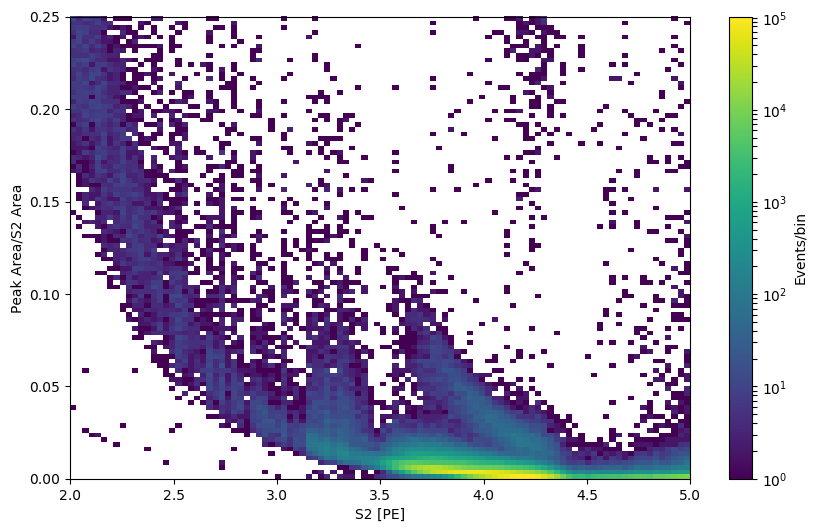

SR1_Rn


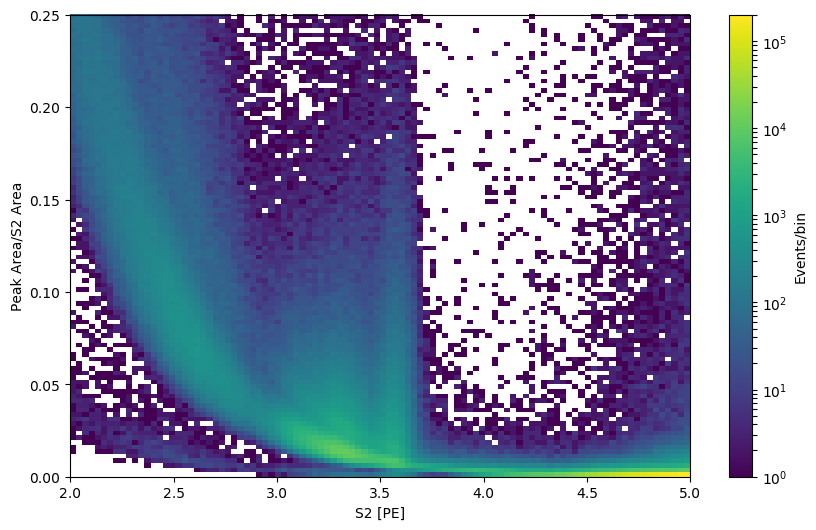

In [13]:
_pi_prob_bins=100
_s2_bins =100
_s2_bins=np.linspace(2, 5, _s2_bins+1)
_pi_prob_bins=np.linspace(0, 0.25, _pi_prob_bins+1)
for key, data in dict_data_sets.items():
    print(key)
    fig = plt.figure(figsize=(10, 6))
    
    plt.hist2d(np.log10(data.s2), data.area/data.s2, bins=[_s2_bins, _pi_prob_bins], range=[[2, 5], [0, 0.2]],
               norm=LogNorm())
    plt.ylabel("Peak Area/S2 Area")
    plt.xlabel("S2 [PE]")
    col_ax=plt.colorbar()
    col_ax.set_label('Events/bin') 
    plt.savefig("fig_%s_pi_after_s2.png" %key)
    plt.savefig("fig_%s_pi_after_s2.png" %key)
    plt.show()

        


SR1_Kr


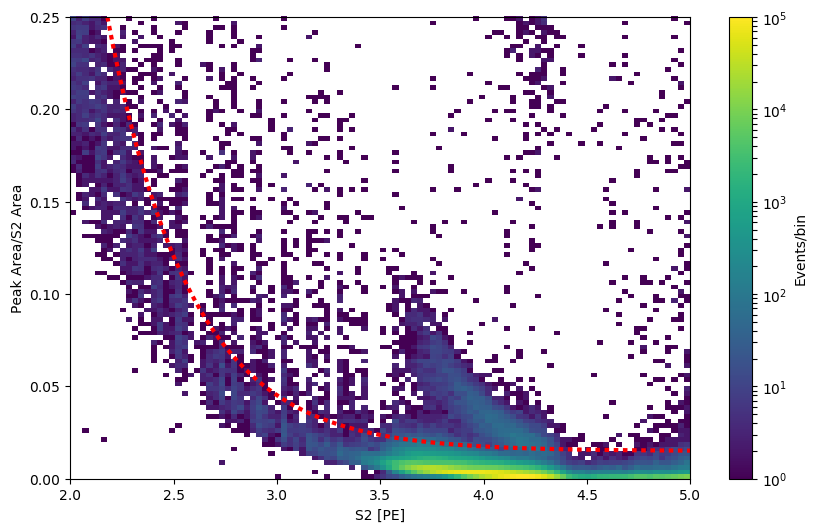

SR1_Rn


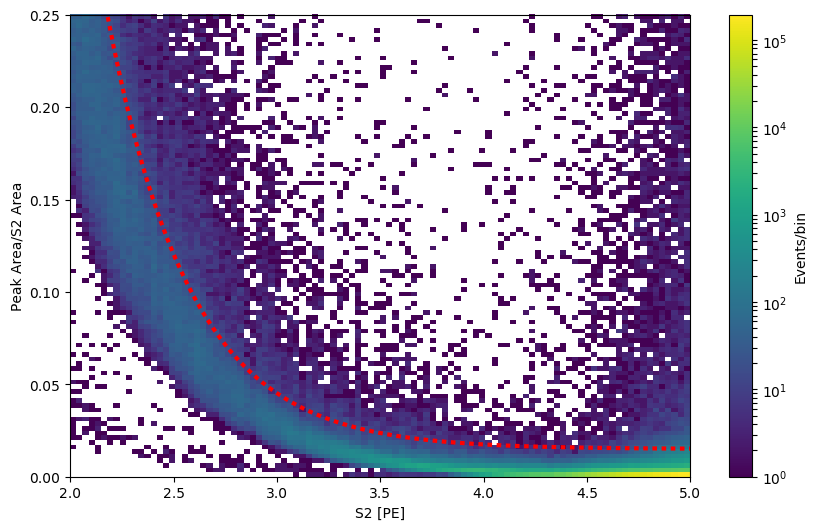

In [14]:
_pi_prob_bins=100
_s2_bins =100
_s2_bins=np.linspace(2, 5, _s2_bins+1)
_pi_prob_bins=np.linspace(0, 0.25, _pi_prob_bins+1)
for key, data in dict_data_sets.items():
    print(key)
    fig = plt.figure(figsize=(10, 6))
    data_temp=data.loc[(data['drift_time'].values/1000>5) ]
    
    plt.plot(_s2_bins, 0.015+np.exp(4-2.5*_s2_bins), color='r', linewidth =3, linestyle=':')
    
    plt.hist2d(np.log10(data_temp.s2), data_temp.area/data_temp.s2, bins=[_s2_bins, _pi_prob_bins], range=[[2, 5], [0, 0.2]],
               norm=LogNorm())
    plt.ylabel("Peak Area/S2 Area")
    plt.xlabel("S2 [PE]")
    col_ax=plt.colorbar()
    col_ax.set_label('Events/bin') 
    #plt.savefig("fig_%s_pi_dt_5us.png" %key)
    #plt.savefig("fig_%s_pi_dt_5us.png" %key)
    plt.show()

### Cut out  Kr peak, BiPos, and Gate(?)

In [15]:
dict_data_reduced={}
for key, data in dict_data_sets.items():
    data['PI'] = data['area']/data['s2']
    data_new = hax.cuts.selection(data, data['drift_time']/1000>5, "Remove BiPos")
    data_new = hax.cuts.selection(data_new, data_new['PI']<(0.015+np.exp(4-2.5*np.log10(data_new['s2']))), "Remove Kr")
    print(key, len(data_new))
    dict_data_reduced.update({key: data_new})

Remove BiPos selection: 192627 rows removed (93.81% passed)
Remove Kr selection: 23366 rows removed (99.20% passed)
SR1_Kr 2898171
Remove BiPos selection: 1033277 rows removed (84.73% passed)
Remove Kr selection: 61659 rows removed (98.92% passed)
SR1_Rn 5670141


### Number of subsequent peaks

In [ ]:
_s2_bins =100
_s2_bins=np.linspace(2, 5, _s2_bins+1)
for key, data in dict_data_reduced.items():
    data_temp = data.loc[data.time_since_s2/1000<720]
    events = data_temp['event_number'].unique()
    event_counts=data_temp.event_number.value_counts()
    n_peak=[]
    s2=[]
    for event in tqdm(events):
        n_peak.append(event_counts[event])
        s2.append(data_temp['event_number']==event)

 18%|█▊        | 25678/140309 [01:26<06:25, 297.38it/s]

### Spatial Distribution of PI Prob

In [29]:
_spatial_bins =30
_temporal_bins=100
_xbins=np.linspace(-47.9, 47.9, _spatial_bins+1)
_ybins=np.linspace(-47.9, 47.9, _spatial_bins+1)
xv, yv = np.meshgrid(_xbins, _ybins)
dict_fit_vals_pe={}
for key, data in dict_data_reduced.items():
    pe_probc = np.zeros((_spatial_bins, _spatial_bins))
    xc = np.zeros_like(pe_probc)
    yc = np.zeros_like(pe_probc)
    print(key)
    for idx, x_edge in enumerate(xv[:-1]):
        for idy, y_edge in enumerate(yv[:-1]):
           
            data_temp=data.loc[(data.x_s2_tpf>xv[idx][idy])&(data.x_s2_tpf<xv[idx][idy+1])
                               &(data.y_s2_tpf>yv[idx][idy])&(data.y_s2_tpf<yv[idx+1][idy])
                               &(data.s2<100000)
                               &(data.time_since_s2/1000<720)]
            
            
            xc[idx, idy]=xv[idx][idy]+(xv[idx][idy+1]-xv[idx][idy])/2
            yc[idx, idy]=yv[idx][idy]+(yv[idx+1][idy]-yv[idx][idy])/2
            rc= np.sqrt(xc[idx, idy]**2+yc[idx, idy]**2)
            
            if len(data_temp)<100:
                pe_probc[idx, idy]=np.nan
                
            else:
                pe_probc[idx, idy]=np.average(data_temp.area/data_temp.s2)
             
               
    dict_fit_vals_pe[key]=[xc, yc, pe_probc]

        


SR1_Kr
SR1_Rn


SR1_Kr


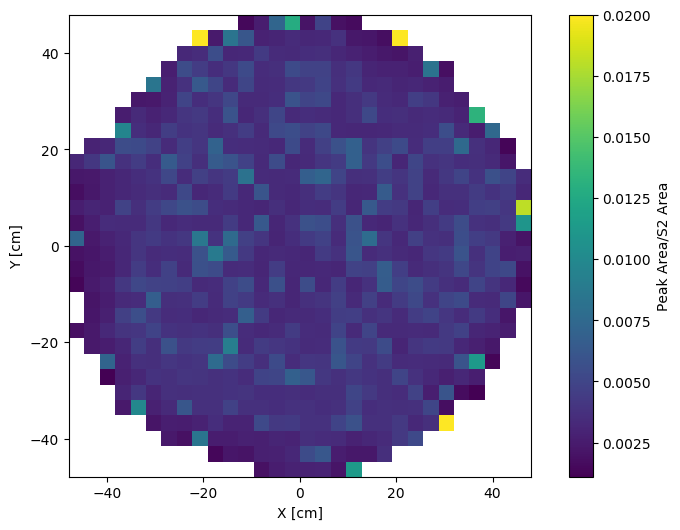

SR1_Rn


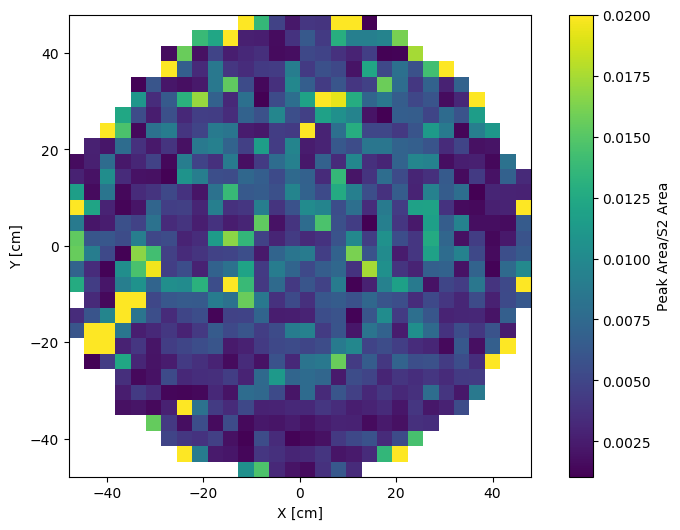

In [30]:
for key, data in dict_fit_vals_pe.items():
    print(key)
    fig = plt.figure(figsize=(10, 6))
    plt.set_cmap("viridis")
    plt.imshow(data[2], extent=[-47.9, 47.9, -47.9, 47.9], vmax=0.02)
    plt.ylabel("Y [cm]")
    plt.xlabel("X [cm]")
    col_ax=plt.colorbar()
    col_ax.set_label("Peak Area/S2 Area") 
    plt.savefig("fig_%s_pi_xy.png" %key)
    plt.savefig("fig_%s_pi_xy.png" %key)
    plt.show()

SR1_Kr
0.00410885026562 0.015319802641275896


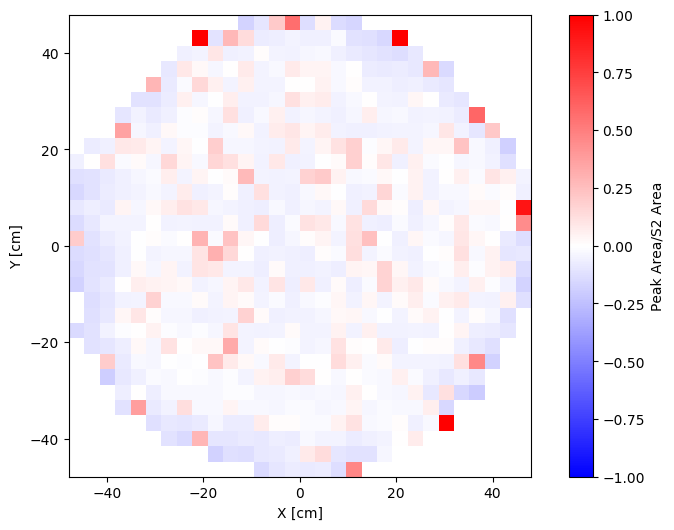

SR1_Rn
0.00571206960797 0.03381584982390119


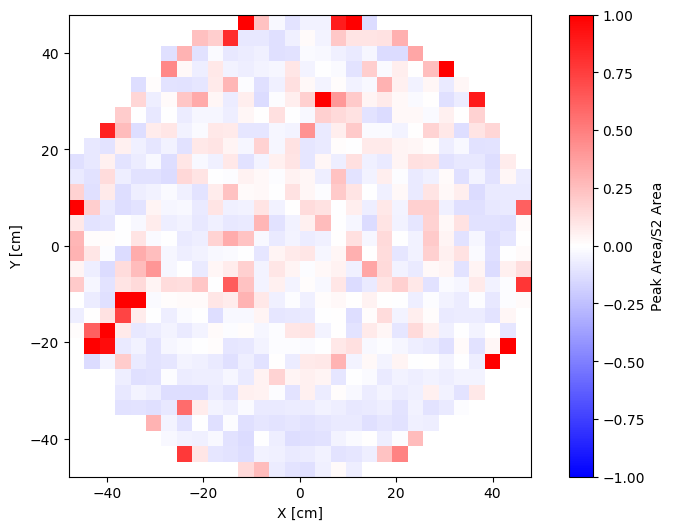

In [31]:
for key, data in dict_fit_vals_pe.items():
    print(key)
    df=dict_data_reduced[key]
    df_temp = df.loc[(df.s2<100000)]
    PI_ave=np.average(df_temp['area']/df_temp['s2'])
    PI_std=np.std(df_temp['area']/df_temp['s2'])
    print(PI_ave, PI_std)
    fig = plt.figure(figsize=(10, 6))
    plt.set_cmap("bwr")
    plt.imshow((data[2]-PI_ave)/PI_std, extent=[-47.9, 47.9, -47.9, 47.9], vmin=-1, vmax=1)
    plt.ylabel("Y [cm]")
    plt.xlabel("X [cm]")
    col_ax=plt.colorbar()
    col_ax.set_label("Deviation [$\sigma$]")  
    plt.savefig("fig_%s_pi_xy_var.png" %key)
    plt.savefig("fig_%s_pi_xy_var.png" %key)
    plt.show()

#### Spatial Distribution in High Energy region

In [19]:
_spatial_bins =30
_temporal_bins=100
_xbins=np.linspace(-47.9, 47.9, _spatial_bins+1)
_ybins=np.linspace(-47.9, 47.9, _spatial_bins+1)
xv, yv = np.meshgrid(_xbins, _ybins)
dict_fit_vals_pe={}
for key, data in dict_data_reduced.items():
    pe_probc = np.zeros((_spatial_bins, _spatial_bins))
    xc = np.zeros_like(pe_probc)
    yc = np.zeros_like(pe_probc)
    print(key)
    for idx, x_edge in enumerate(xv[:-1]):
        for idy, y_edge in enumerate(yv[:-1]):
           
            data_temp=data.loc[(data.x_s2_tpf>xv[idx][idy])&(data.x_s2_tpf<xv[idx][idy+1])
                               &(data.y_s2_tpf>yv[idx][idy])&(data.y_s2_tpf<yv[idx+1][idy])
                               &(data.s2<100000)
                               &(data.time_since_s2/1000<720)
                               &(np.log10(data.s2)>3.5)]
            
            
            xc[idx, idy]=xv[idx][idy]+(xv[idx][idy+1]-xv[idx][idy])/2
            yc[idx, idy]=yv[idx][idy]+(yv[idx+1][idy]-yv[idx][idy])/2
            rc= np.sqrt(xc[idx, idy]**2+yc[idx, idy]**2)
            
            if len(data_temp)<100:
                pe_probc[idx, idy]=np.nan
                
            else:
                pe_probc[idx, idy]=np.average(data_temp.area/data_temp.s2)
             
               
    dict_fit_vals_pe[key]=[xc, yc, pe_probc]

        


SR1_Kr
SR1_Rn


SR1_Kr


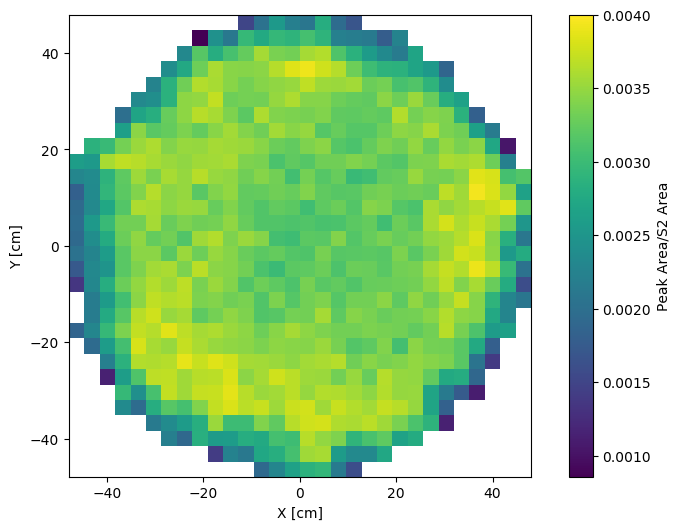

SR1_Rn


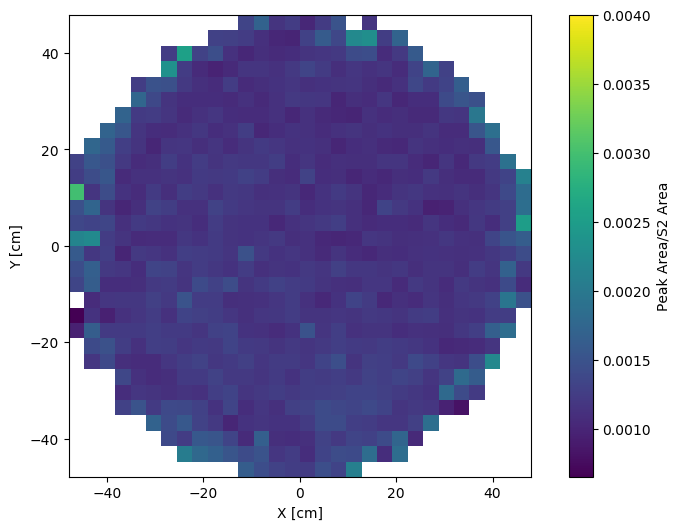

In [27]:
for key, data in dict_fit_vals_pe.items():
    print(key)
    fig = plt.figure(figsize=(10, 6))
    plt.set_cmap("viridis")
    plt.imshow(data[2], extent=[-47.9, 47.9, -47.9, 47.9], vmax=0.004)
    plt.ylabel("Y [cm]")
    plt.xlabel("X [cm]")
    col_ax=plt.colorbar()
    col_ax.set_label("Peak Area/S2 Area") 
    plt.savefig("fig_%s_pi_xy_highE.png" %key)
    plt.savefig("fig_%s_pi_xy_highE.png" %key)
    plt.show()

SR1_Kr
0.00334900719342 0.002103343518679094


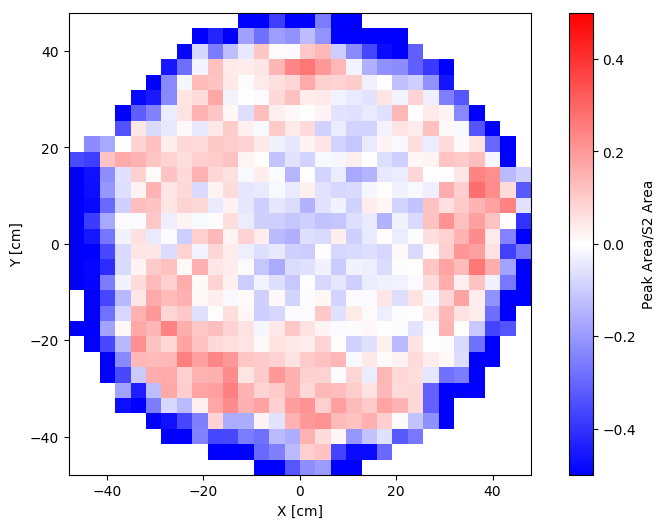

SR1_Rn
0.00128284641518 0.0019464596268196454


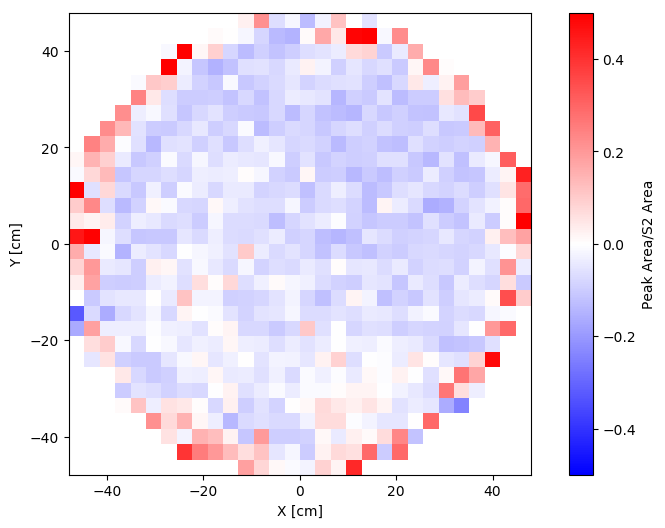

In [28]:
for key, data in dict_fit_vals_pe.items():
    print(key)
    df=dict_data_reduced[key]
    df_temp = df.loc[(df.s2<100000)&(np.log10(df.s2)>3.5)]
    PI_ave=np.average(df_temp['area']/df_temp['s2'])
    PI_std=np.std(df_temp['area']/df_temp['s2'])
    print(PI_ave, PI_std)
    fig = plt.figure(figsize=(10, 6))
    plt.set_cmap("bwr")
    plt.imshow((data[2]-PI_ave)/PI_std, extent=[-47.9, 47.9, -47.9, 47.9], vmin=-0.5, vmax=0.5)
    plt.ylabel("Y [cm]")
    plt.xlabel("X [cm]")
    col_ax=plt.colorbar()
    col_ax.set_label("Deviation [$\sigma$]") 
    plt.savefig("fig_%s_pi_xy_var_highE.png" %key)
    plt.savefig("fig_%s_pi_xy_var_highE.png" %key)
    plt.show()

#### Spatial Distribution in Low Energy region

In [36]:
_spatial_bins =30
_temporal_bins=100
_xbins=np.linspace(-47.9, 47.9, _spatial_bins+1)
_ybins=np.linspace(-47.9, 47.9, _spatial_bins+1)
xv, yv = np.meshgrid(_xbins, _ybins)
dict_fit_vals_pe={}
for key, data in dict_data_reduced.items():
    pe_probc = np.zeros((_spatial_bins, _spatial_bins))
    xc = np.zeros_like(pe_probc)
    yc = np.zeros_like(pe_probc)
    print(key)
    for idx, x_edge in enumerate(xv[:-1]):
        for idy, y_edge in enumerate(yv[:-1]):
           
            data_temp=data.loc[(data.x_s2_tpf>xv[idx][idy])&(data.x_s2_tpf<xv[idx][idy+1])
                               &(data.y_s2_tpf>yv[idx][idy])&(data.y_s2_tpf<yv[idx+1][idy])
                               &(data.s2<100000)
                               &(data.time_since_s2/1000<720)
                               &(np.log10(data.s2)<3.5)]
            
            
            xc[idx, idy]=xv[idx][idy]+(xv[idx][idy+1]-xv[idx][idy])/2
            yc[idx, idy]=yv[idx][idy]+(yv[idx+1][idy]-yv[idx][idy])/2
            rc= np.sqrt(xc[idx, idy]**2+yc[idx, idy]**2)
            
            if len(data_temp)<10:
                pe_probc[idx, idy]=np.nan
                
            else:
                pe_probc[idx, idy]=np.average(data_temp.area/data_temp.s2)
             
               
    dict_fit_vals_pe[key]=[xc, yc, pe_probc]

        


SR1_Kr
SR1_Rn


SR1_Kr


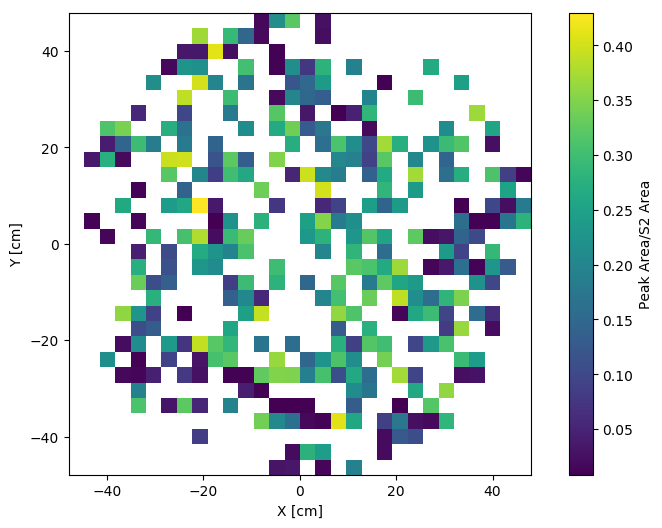

SR1_Rn


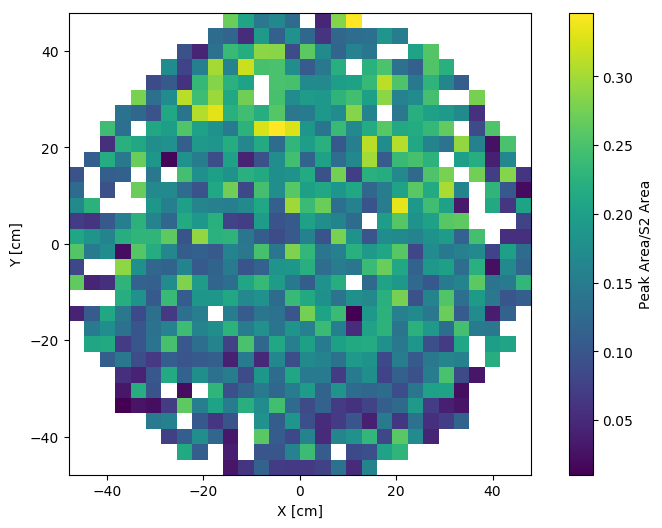

In [37]:
for key, data in dict_fit_vals_pe.items():
    print(key)
    fig = plt.figure(figsize=(10, 6))
    plt.set_cmap("viridis")
    plt.imshow(data[2], extent=[-47.9, 47.9, -47.9, 47.9],)
    plt.ylabel("Y [cm]")
    plt.xlabel("X [cm]")
    col_ax=plt.colorbar()
    col_ax.set_label("Peak Area/S2 Area") 
    plt.savefig("fig_%s_pi_xy_lowE.png" %key)
    plt.savefig("fig_%s_pi_xy_lowE.png" %key)
    plt.show()

SR1_Kr
0.178560198232 0.14703654040623773


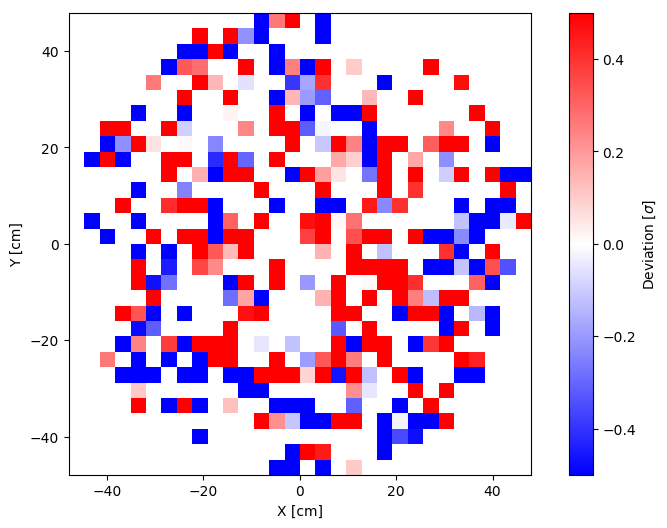

SR1_Rn
0.156083277344 0.1254628729719696


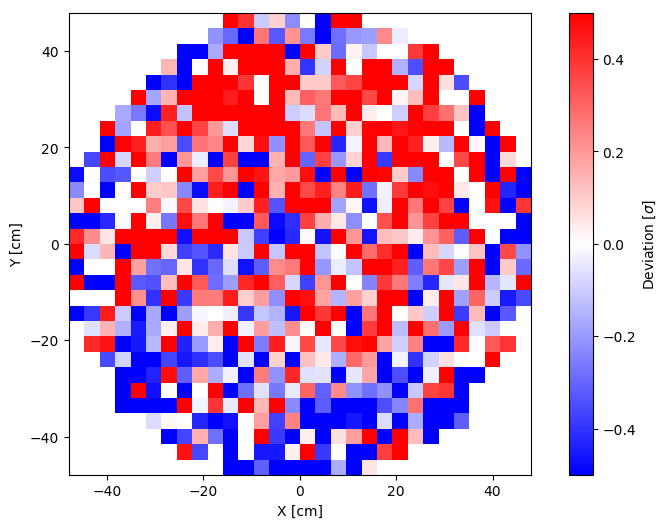

In [54]:
for key, data in dict_fit_vals_pe.items():
    print(key)
    df=dict_data_reduced[key]
    df_temp = df.loc[(df.s2<100000)&(np.log10(df.s2)<3.5)]
    PI_ave=np.average(df_temp['area']/df_temp['s2'])
    PI_std=np.std(df_temp['area']/df_temp['s2'])
    print(PI_ave, PI_std)
    fig = plt.figure(figsize=(10, 6))
    plt.set_cmap("bwr")
    plt.imshow((data[2]-PI_ave)/PI_std, extent=[-47.9, 47.9, -47.9, 47.9], vmin=-0.5, vmax=0.5)
    plt.ylabel("Y [cm]")
    plt.xlabel("X [cm]")
    col_ax=plt.colorbar()
    col_ax.set_label("Deviation [$\sigma$]") 
    plt.savefig("fig_%s_pi_xy_var_lowE.png" %key)
    plt.savefig("fig_%s_pi_xy_var_lowE.png" %key)
    plt.show()

### Electron "Lifetime" High E

In [62]:
_spatial_bins =30
_temporal_bins=100
_xbins=np.linspace(-47.9, 47.9, _spatial_bins+1)
_ybins=np.linspace(-47.9, 47.9, _spatial_bins+1)
_dtrange=[20,800]
xv, yv = np.meshgrid(_xbins, _ybins)
dict_fit_vals={}
for key, data in dict_data_sets.items():
    dtc = np.zeros((_spatial_bins, _spatial_bins))
    xc = np.zeros_like(dtc)
    yc = np.zeros_like(dtc)
    print(key)
    for idx, x_edge in enumerate(xv[:-1]):
        for idy, y_edge in enumerate(yv[:-1]):
            data_temp=data.loc[(data.x_s2_tpf>xv[idx][idy])&(data.x_s2_tpf<xv[idx][idy+1])
                               &(data.y_s2_tpf>yv[idx][idy])&(data.y_s2_tpf<yv[idx+1][idy])
                               &(data.s2<100000)
                               &(np.log10(data.s2)>3.5)]
            
            xc[idx, idy]=xv[idx][idy]+(xv[idx][idy+1]-xv[idx][idy])/2
            yc[idx, idy]=yv[idx][idy]+(yv[idx+1][idy]-yv[idx][idy])/2
            rc= np.sqrt(xc[idx, idy]**2+yc[idx, idy]**2)
            #if rc>47.9:
            if len(data_temp)<1000:
                dtc[idx, idy]=np.nan
                
            else:  
                #Make Hist
                #fig = plt.figure(figsize=(16, 6))
                (hist, bin_edges) = np.histogram(data_temp['time_since_s2'].values/1000, 
                                                 bins = _temporal_bins, range = _dtrange)
                hist_err=np.sqrt(hist)
                bins_width = (bin_edges[1:] - bin_edges[:-1])/2
                bin_centers = bin_edges[:-1] + bins_width
                #plt.plot(bin_centers, np.log(hist), linewidth=3,  color='r')

                #Find maximum
                i_max_index = np.argmax(hist)
                #plt.axvline(bin_centers[i_max_index], ymin=0, ymax=1)

                #Fit data
                if 'SR1' in key:
                    i_last_index = np.searchsorted(bin_centers, 720, side="left")
                    #plt.axvline(bin_centers[i_last_index], ymin=0, ymax=1)
                if 'SR0' in key:
                    i_last_index = np.searchsorted(bin_centers, 660, side="left")
                    #plt.axvline(bin_centers[i_last_index], ymin=0, ymax=1)
                try:
                    (f_slope, _, f_slope_err, _, _, f_chisq) = fit_straight_line([-1, 5], np.log(hist[i_max_index:i_last_index]), 
                                                                         bin_edges[i_max_index:i_last_index+1])
                except ValueError:
                    f_slope=np.nan
                #plt.show()
                dtc[idx, idy]=-1/f_slope
                
    dict_fit_vals[key]=[xc, yc, dtc]

        


SR1_Kr


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log


SR1_Rn


SR1_Kr


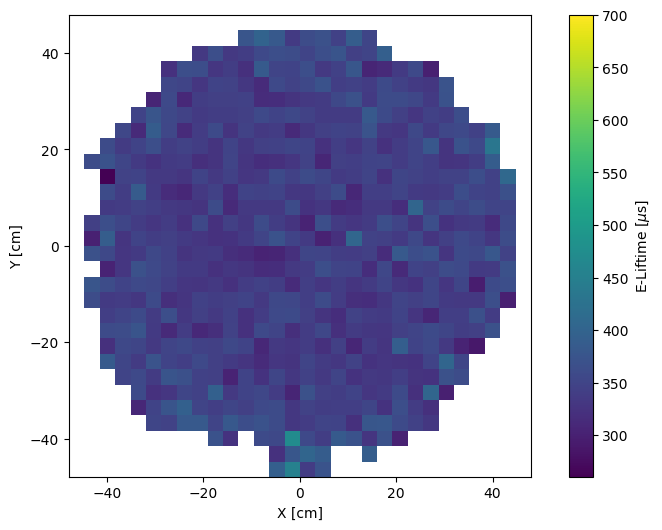

SR1_Rn


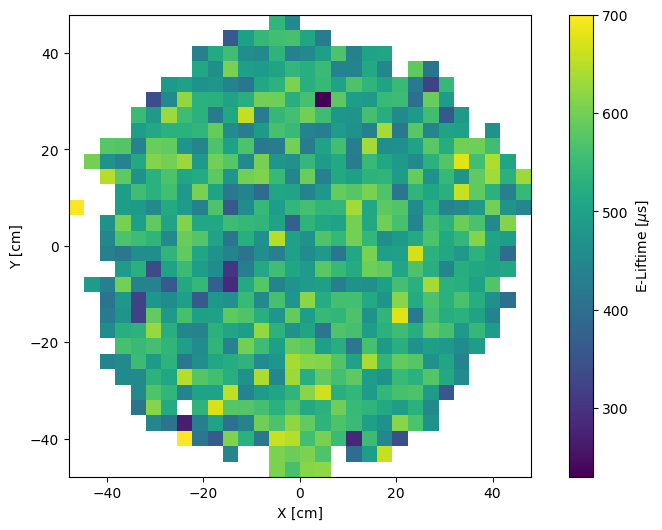

In [65]:
for key, data in dict_fit_vals.items():
    print(key)
    fig = plt.figure(figsize=(10, 6))
    plt.set_cmap("viridis")
    plt.imshow(data[2], extent=[-47.9, 47.9, -47.9, 47.9], vmax=700)
    plt.ylabel("Y [cm]")
    plt.xlabel("X [cm]")
    col_ax=plt.colorbar()
    col_ax.set_label("E-Liftime [$\mu$s]") 
    plt.savefig("fig_%s_xy_elife.png" %key)
    plt.savefig("fig_%s_xy_elife.png" %key)
    plt.show()

SR1_Kr
0.189175768984 0.118237779738


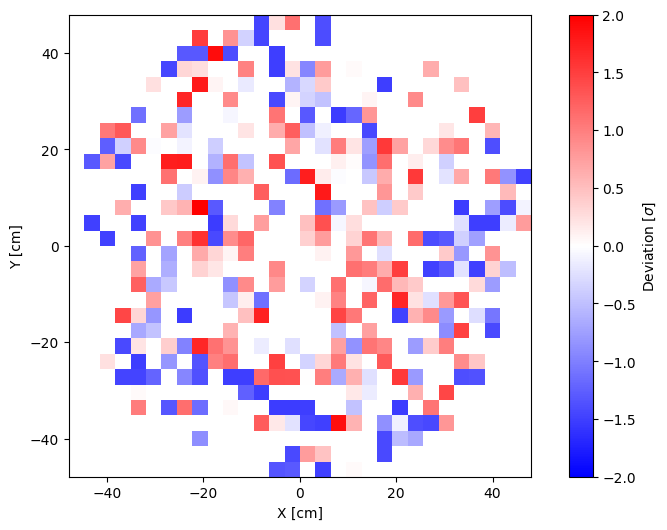

SR1_Rn
0.164730255302 0.0677381149983


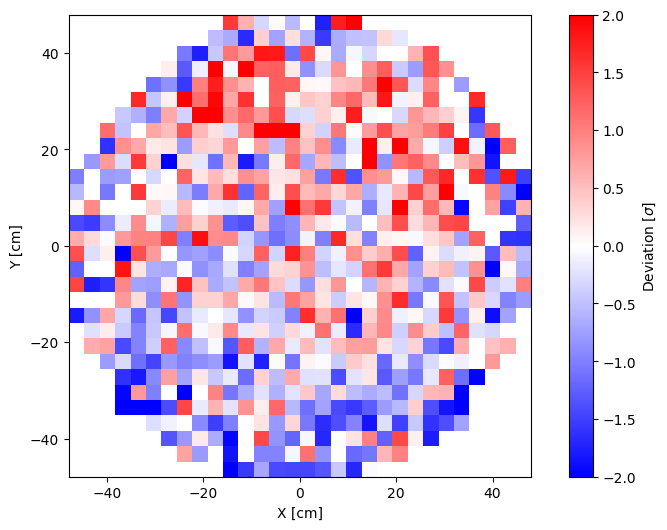

In [67]:
for key, data in dict_fit_vals_pe.items():
    print(key)
    El_ave=np.nanmean(data[2])
    El_std=np.nanstd(data[2])
    print(El_ave, El_std)
    fig = plt.figure(figsize=(10, 6))
    plt.set_cmap("bwr")
    plt.imshow((data[2]-El_ave)/El_std, extent=[-47.9, 47.9, -47.9, 47.9], vmin=-2, vmax=2)
    plt.ylabel("Y [cm]")
    plt.xlabel("X [cm]")
    col_ax=plt.colorbar()
    col_ax.set_label("Deviation [$\sigma$]") 
    plt.savefig("fig_%s_xy_elife_var.png" %key)
    plt.savefig("fig_%s_xy_elife_var.png" %key)
    plt.show()